In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import holidays 
from datetime import datetime, date
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [2]:
forecast = pd.read_csv('train.csv')

In [ ]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [27]:
forecast.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [13]:
forecast.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [14]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [3]:
#forecast["date"] = pd.to_datetime(forecast.date)

In [29]:
forecast.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       913000 non-null  datetime64[ns]
 1   store      913000 non-null  int64         
 2   item       913000 non-null  int64         
 3   sales      913000 non-null  int64         
 4   dayofweek  913000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 34.8 MB


## Neural Net

In [18]:
def createmodeldataframeold(mydf):
    mydf["date"] = pd.to_datetime(mydf.date)
    mydf['dayofweek'] = mydf['date'].apply(lambda x:x.weekday())
    mydf['month'] = mydf['date'].apply(lambda x: x.month)
    mydf['dayinmonth'] = mydf['date'].apply(lambda x: x.day)
    mydf['dayinyear'] = mydf['date'].apply(lambda x: x.timetuple().tm_yday)
    mydf['year'] = mydf['date'].apply(lambda x: x.year)
    usholidays = holidays.US()
    mydf['US_holiday'] = mydf['date'].apply(lambda x: x in usholidays).astype(int)
    ohe = OneHotEncoder()
    df3 = pd.DataFrame(ohe.fit_transform(mydf[["store","item"]]).toarray())
    lastforecast=pd.concat([mydf,df3],axis=1)
    cleanforecast = lastforecast.drop(['date','store','item'], axis=1)
    return cleanforecast

In [3]:
def createmodeldataframe(mydf):
    mydf["date"] = pd.to_datetime(mydf.date)
    mydf['dayofweek'] = mydf['date'].apply(lambda x:np.cos((2*np.pi*(x.weekday())/7)-.4))
    mydf['month'] = mydf['date'].apply(lambda x: np.cos((2*np.pi*x.month/12)-.1))
    mydf['dayinmonth'] = mydf['date'].apply(lambda x: np.cos((2*np.pi*x.day/30)-.1))
    mydf['dayinyear'] = mydf['date'].apply(lambda x: np.cos((2*np.pi*x.timetuple().tm_yday/365)-.01))
    mydf['year'] = mydf['date'].apply(lambda x: x.year)
    usholidays = holidays.US()
    mydf['US_holiday'] = mydf['date'].apply(lambda x: x in usholidays).astype(int)
    ohe = OneHotEncoder()
    df3 = pd.DataFrame(ohe.fit_transform(mydf[["store","item"]]).toarray())
    lastforecast=pd.concat([mydf,df3],axis=1)
    cleanforecast = lastforecast.drop(['date','store','item'], axis=1)
    return cleanforecast

In [5]:
# add day of week
#forecast['dayofweek'] = forecast['date'].apply(lambda x:x.weekday())
#forecast['dayofweek'] = forecast['date'].apply(lambda x:np.cos((2*np.pi*(x.weekday())/7)-.4))

In [7]:
#add month
#forecast['month'] = forecast['date'].apply(lambda x: x.month)
#forecast['month'] = forecast['date'].apply(lambda x: np.cos((2*np.pi*x.month/12)-.1))

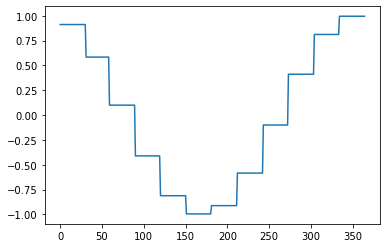

In [8]:
# add day of month
#forecast['dayinmonth'] = forecast['date'].apply(lambda x: x.day)
#forecast['dayinmonth'] = forecast['date'].apply(lambda x: np.cos((2*np.pi*x.day/30)-.1))

In [9]:
# add day in the year
#forecast['dayinyear'] = forecast['date'].apply(lambda x: x.timetuple().tm_yday)
#forecast['dayinyear'] = forecast['date'].apply(lambda x: np.cos((2*np.pi*x.timetuple().tm_yday/365)-.01))

In [10]:
#add year
#forecast['year'] = forecast['date'].apply(lambda x: x.year)

In [11]:
#holiday or not
#usholidays = holidays.US()
#forecast['US_holiday'] = forecast['date'].apply(lambda x: x in usholidays).astype(int)

In [12]:
#from sklearn.preprocessing import OneHotEncoder
#ohe = OneHotEncoder()
#df3 = pd.DataFrame(ohe.fit_transform(forecast[["store","item"]]).toarray())
#lastforecast=pd.concat([forecast,df3],axis=1)


In [13]:
#cleanforecast = lastforecast.drop(['date','store','item'], axis=1)

In [6]:
cleanforecast = createmodeldataframe(train)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

In [17]:
#other way to split to predict last month
#month_prediction = 31
#train_forecast = cleanforecast[:-month_prediction]
#test_forecast = cleanforecast[-month_prediction:]
#X_forecasttrain = train_forecast.drop('sales', axis=1)
#y_forecasttrain = train_forecast['sales']
#X_forecasttest = test_forecast.drop('sales', axis=1)
#y_forecasttest = test_forecast['sales']


#scaler = MinMaxScaler()
#X_forecasttrain = scaler.fit_transform(X_forecasttrain)
#X_forecasttest = scaler.fit_transform(X_forecasttest)

In [ ]:
X_train = cleanforecast.drop('sales', axis=1)
y_train = cleanforecast['sales']

In [56]:
#Split the data into training and testing sets.
#X_train, X_test, y_train, y_test = train_test_split(cleanforecast.drop('sales', axis=1), 
                                                    cleanforecast.sales, test_size = 1,random_state = 101)


#Scaling the data because the data varies a lot(check X.describe())
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
#X_test = scaler.fit_transform(X_test)

ValueError: test_size=0 should be either positive and smaller than the number of samples 913000 or a float in the (0, 1) range

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [24]:
model = Sequential()

model.add(Dense(66,activation='relu'))
model.add(Dense(40,activation='relu'))
model.add(Dropout(.3))
model.add(Dense(30,activation='relu'))
model.add(Dropout(.2))
model.add(Dense(20,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [25]:
# add early stopping
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=256,epochs=60)

Epoch 1/100
2854/2854 [==============================] - 6s 2ms/step - loss: 261.0683 - val_loss: 276.7237
Epoch 2/100
2854/2854 [==============================] - 6s 2ms/step - loss: 116.0446 - val_loss: 251.6211
Epoch 3/100
2854/2854 [==============================] - 6s 2ms/step - loss: 107.7067 - val_loss: 204.5998
Epoch 4/100
2854/2854 [==============================] - 6s 2ms/step - loss: 102.8450 - val_loss: 209.5211
Epoch 5/100
2854/2854 [==============================] - 6s 2ms/step - loss: 96.7668 - val_loss: 209.5118
Epoch 6/100
2854/2854 [==============================] - 6s 2ms/step - loss: 91.0143 - val_loss: 189.4289
Epoch 7/100
2854/2854 [==============================] - 6s 2ms/step - loss: 87.6196 - val_loss: 172.6758
Epoch 8/100
2854/2854 [==============================] - 6s 2ms/step - loss: 85.5829 - val_loss: 195.8082
Epoch 9/100
2854/2854 [==============================] - 6s 2ms/step - loss: 84.0019 - val_loss: 173.1419
Epoch 10/100
2854/2854 [==================

In [47]:
#preds = preds**1.07

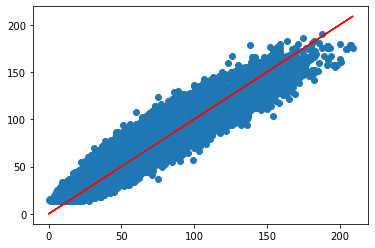

In [48]:
#preds = model.predict(X_test)
plt.scatter(y_test,preds)
plt.plot(y_test,y_test,'r')
#maybe use transformation

In [22]:
X_train.shape

(912899, 66)

In [27]:
#second type of model
#model.fit(x=X_forecasttrain,y=y_forecasttrain.values,
#          validation_data=(X_forecasttest,y_forecasttest.values),
#          batch_size=128,epochs=200)

Epoch 1/200
7133/7133 [==============================] - 9s 1ms/step - loss: 58.4691 - val_loss: 1105.9977
Epoch 2/200
7133/7133 [==============================] - 9s 1ms/step - loss: 58.3860 - val_loss: 1088.1471
Epoch 3/200
7133/7133 [==============================] - 9s 1ms/step - loss: 58.4157 - val_loss: 1155.6641
Epoch 4/200
7133/7133 [==============================] - 9s 1ms/step - loss: 58.4358 - val_loss: 1167.1068
Epoch 5/200
7133/7133 [==============================] - 9s 1ms/step - loss: 58.4302 - val_loss: 1175.6696
Epoch 6/200
7133/7133 [==============================] - 9s 1ms/step - loss: 58.4379 - val_loss: 1169.5997
Epoch 7/200
7133/7133 [==============================] - 9s 1ms/step - loss: 58.3895 - val_loss: 1169.3898
Epoch 8/200
7133/7133 [==============================] - 10s 1ms/step - loss: 58.3421 - val_loss: 1168.5221
Epoch 9/200
7133/7133 [==============================] - 9s 1ms/step - loss: 58.3139 - val_loss: 1200.4706
Epoch 10/200
7133/7133 [============

Epoch 77/200
7133/7133 [==============================] - 9s 1ms/step - loss: 57.5051 - val_loss: 1320.9357
Epoch 78/200
7133/7133 [==============================] - 9s 1ms/step - loss: 57.5344 - val_loss: 1382.4995
Epoch 79/200
7133/7133 [==============================] - 9s 1ms/step - loss: 57.4287 - val_loss: 1408.0471
Epoch 80/200
7133/7133 [==============================] - 9s 1ms/step - loss: 57.4588 - val_loss: 1361.0560
Epoch 81/200
7133/7133 [==============================] - 9s 1ms/step - loss: 57.4763 - val_loss: 1364.0703
Epoch 82/200
7133/7133 [==============================] - 9s 1ms/step - loss: 57.4246 - val_loss: 1367.6129
Epoch 83/200
7133/7133 [==============================] - 9s 1ms/step - loss: 57.4693 - val_loss: 1383.4684
Epoch 84/200
7133/7133 [==============================] - 9s 1ms/step - loss: 57.4487 - val_loss: 1347.6246
Epoch 85/200
7133/7133 [==============================] - 9s 1ms/step - loss: 57.3926 - val_loss: 1328.7158
Epoch 86/200
7133/7133 [====

KeyboardInterrupt: 

In [36]:
#losses = pd.DataFrame(model.history.history)

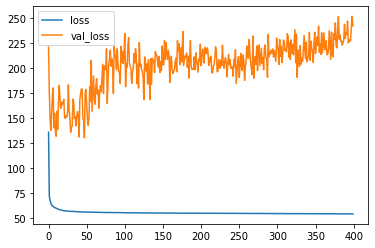

In [37]:
#losses.plot()

## Submission

In [54]:
testdf = pd.read_csv("test.csv")
testdata = createmodeldataframe(testdf)
testids = testdata.id
testdata.drop('id',axis=1, inplace=True)
testdata = scaler.fit_transform(testdata)
testpreds = model.predict(testdata)
testpreds = testpreds**1.07

In [ ]:
# Create submission
sub = pd.DataFrame({'id':testids,'sales':testpreds})
sub.to_csv('submission.csv', index=False)
sub.head()